In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import gc

In [2]:
test_df = pd.read_csv('datasets/test.csv.gz', dtype={'ID': np.int32,
                                                    'shop_id': np.int32,
                                                    'item_id': np.int32})
test_df

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [3]:
item_df = pd.read_csv('datasets/items.csv')
item_df

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [4]:
sales_df = pd.read_csv('datasets/sales_train.csv.gz')
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%d.%m.%Y')
sales_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [5]:
sales_df.isna().sum(axis=0)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


<AxesSubplot:xlabel='date'>

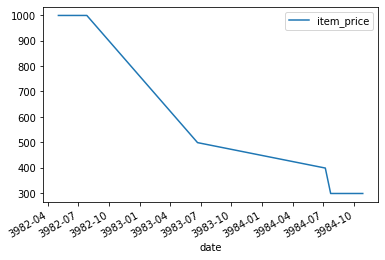

In [6]:
sample_item = sales_df.sample(1, random_state=123)
shop_id = sample_item['shop_id'].values[0]
item_id = sample_item['item_id'].values[0]
item_sales_df = sales_df[(sales_df['shop_id'] == shop_id) & (sales_df['item_id'] == item_id)].sort_values('date')
item_sales_df.plot(x='date', y='item_price')

In [7]:

def downcast_dataframe(df):
    dtype_mapper = {
        'int64': 'int32',
        'float64': 'float32'
    }
    dtypes = df.dtypes.to_dict()

    new_dtypes = {col: dtype_mapper.get(str(dtype), str(dtype)) for col, dtype in dtypes.items()}
    return df.astype(new_dtypes)

In [8]:
monthly_sales_df = sales_df.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False) \
                            .agg({'item_price': 'mean', 'item_cnt_day': 'sum'})
monthly_sales_df.rename(columns={'item_cnt_day': 'count'}, inplace=True)
del sales_df, item_sales_df
gc.collect()
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count
0,0,30,1,265.0,31.0
1,0,31,1,434.0,11.0
2,0,32,0,221.0,6.0
3,0,32,1,221.0,10.0
4,0,33,0,347.0,3.0
...,...,...,...,...,...
1609119,59,22164,27,699.0,2.0
1609120,59,22164,30,699.0,1.0
1609121,59,22167,9,299.0,1.0
1609122,59,22167,11,299.0,2.0


<AxesSubplot:xlabel='item_price', ylabel='count'>

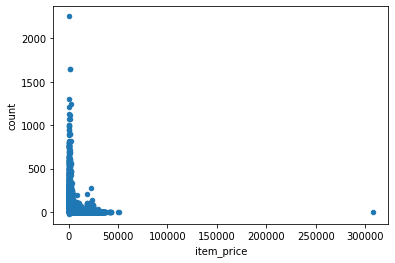

In [9]:
# prices = resampled_sales_df['item_price']
# counts = resampled_sales_df['item_cnt_day']

# resampled_sales_df = resampled_sales_df[((prices > prices.quantile(0.01)) & (prices < prices.quantile(0.99))) &
#                                         ((counts > counts.quantile(0.01)) & (counts < counts.quantile(0.99)))]
monthly_sales_df.plot.scatter(x='item_price', y='count')

In [10]:
monthly_sales_df = monthly_sales_df.merge(item_df[['item_id', 'item_category_id']], on='item_id')
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id
0,0,30,1,265.0,31.0,40
1,1,30,1,265.0,10.0,40
2,2,30,2,359.0,1.0,40
3,2,30,5,399.0,1.0,40
4,2,30,15,169.0,1.0,40
...,...,...,...,...,...,...
1609119,59,9760,12,179.0,1.0,37
1609120,59,12846,10,149.0,1.0,37
1609121,59,16270,6,1000.0,1.0,75
1609122,59,17732,9,198.0,1.0,28


In [11]:

monthly_sales_df = downcast_dataframe(monthly_sales_df)

In [12]:
monthly_sales_df.describe()

,shop_id,item_id,date_block_num,item_price,count,item_category_id
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,3.280585e+01,1.068099e+04,1.466479e+01,7.908846e+02,2.267200e+00,4.154192e+01
std,1.653701e+01,6.238883e+03,9.542322e+00,1.551605e+03,8.649882e+00,1.632365e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01,0.000000e+00
25%,2.100000e+01,5.045000e+03,6.000000e+00,1.990000e+02,1.000000e+00,3.000000e+01
50%,3.100000e+01,1.049700e+04,1.400000e+01,3.990000e+02,1.000000e+00,4.000000e+01
75%,4.700000e+01,1.606000e+04,2.300000e+01,8.985000e+02,2.000000e+00,5.500000e+01
max,5.900000e+01,2.216900e+04,3.300000e+01,3.079800e+05,2.253000e+03,8.300000e+01


### Prove the sales of any shop are different and unique

Text(0, 0.5, 'item_count')

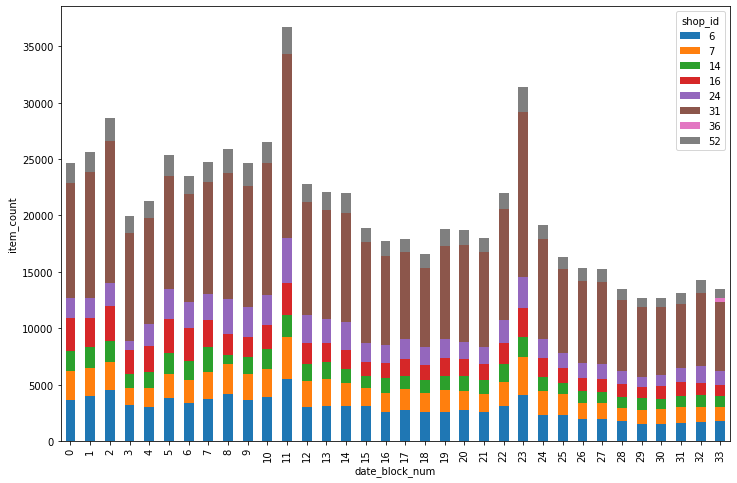

In [56]:
shop_ids = monthly_sales_df['shop_id']
selected_shop_ids = shop_ids.drop_duplicates().sample(8, random_state=99)

ax = monthly_sales_df[shop_ids.isin(selected_shop_ids)].groupby(['date_block_num', 'shop_id']).agg(
    {'count': 'sum'}).unstack().plot.bar(y='count', stacked=True, figsize=(12, 8))
ax.set_ylabel('item_count')

### Prove the sales of any item categories are different

<AxesSubplot:xlabel='date_block_num'>

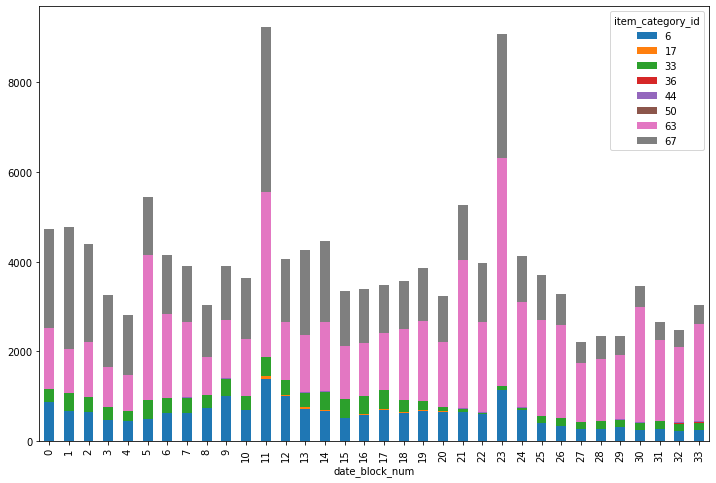

In [58]:
categories = monthly_sales_df['item_category_id']
selected_categories = categories.drop_duplicates().sample(8, random_state=1)
monthly_sales_df[categories.isin(selected_categories)].groupby(['date_block_num', 'item_category_id']).agg(
    {'count': 'sum'}).unstack().plot.bar(y='count', stacked=True, figsize=(12, 8))

### Distribution

In [59]:
def IQR(data, lower, upper):
    return data[(data > data.quantile(lower)) & (data < data.quantile(upper))]


<AxesSubplot:>

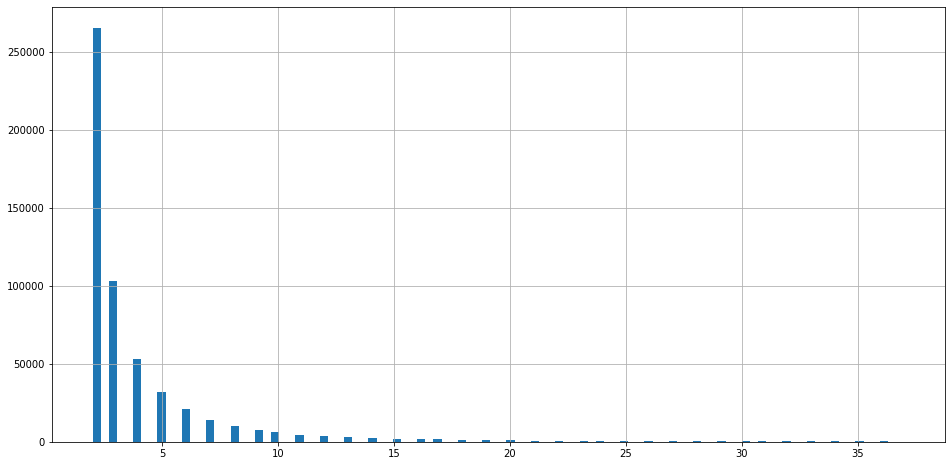

In [60]:
alpha = 0.0027
IQR(monthly_sales_df['count'], alpha, 1-alpha).hist(bins=100, figsize=(16, 8))

<AxesSubplot:>

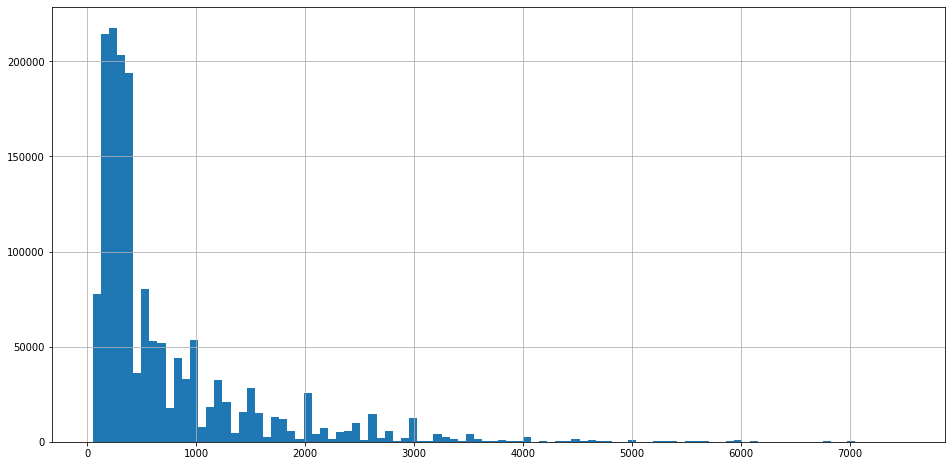

In [61]:
alpha = 0.008
IQR(monthly_sales_df['item_price'], alpha, 1-alpha).hist( bins=100, figsize=(16, 8))

In [62]:
monthly_sales_df.set_index(['shop_id', 'item_id', 'date_block_num']).head(20)

item_price  count  item_category_id
shop_id item_id date_block_num                                     
0       30      1                    265.0   31.0                40
1       30      1                    265.0   10.0                40
2       30      2                    359.0    1.0                40
                5                    399.0    1.0                40
                15                   169.0    1.0                40
                16                   169.0    1.0                40
3       30      1                    399.0    4.0                40
                2                    399.0    5.0                40
                3                    399.0    2.0                40
                4                    399.0    2.0                40
                5                    399.0    1.0                40
                9                    169.0    1.0                40
                10                   169.0    1.0                40
                11                   169.0    2.0                40
                12                   169.0    1.0                40
                30                   129.0    1.0                40
4       30      1                    399.0    7.0                40
                2                    399.0    3.0                40
                7                    399.0    1.0                40
5       30      1                    399.0    5.0                40

In [63]:
monthly_sales_df.nunique()

shop_id                60
item_id             21807
date_block_num         34
item_price          41464
count                 446
item_category_id       84
dtype: int64

In [64]:
test_df.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [65]:
gc.collect()

122

### Clip count

<AxesSubplot:ylabel='Frequency'>

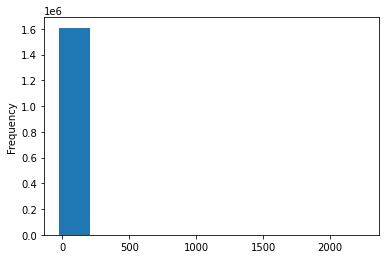

In [13]:
monthly_sales_df['count'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

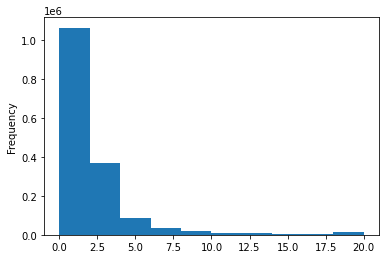

In [14]:
monthly_sales_df['count'].clip(0, 20, inplace=True)
monthly_sales_df['count'].plot.hist()

### Create monthly_sales_df backup 

In [15]:
_monthly_sales_df = monthly_sales_df.copy()

In [16]:
_monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id
0,0,30,1,265.0,20.0,40
1,1,30,1,265.0,10.0,40
2,2,30,2,359.0,1.0,40
3,2,30,5,399.0,1.0,40
4,2,30,15,169.0,1.0,40
...,...,...,...,...,...,...
1609119,59,9760,12,179.0,1.0,37
1609120,59,12846,10,149.0,1.0,37
1609121,59,16270,6,1000.0,1.0,75
1609122,59,17732,9,198.0,1.0,28


## Feature Engineering

In [17]:
def generate_feature(df, by, base_col, output_col, agg_func):
    agg_df = df.groupby(by, as_index=False).agg({base_col: agg_func})
    agg_df.rename(columns={base_col: output_col}, inplace=True)
    return df.merge(agg_df, how='left', on=by)

In [18]:
monthly_sales_df = _monthly_sales_df.copy()
monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'shop_id', 'date_block_num'], base_col='count', output_col='count_by_shop', agg_func='sum')
monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'item_id', 'date_block_num'], base_col='count', output_col='count_by_item', agg_func='sum')
monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'item_category_id', 'date_block_num'], base_col='count', output_col='count_by_item_cat', agg_func='sum')

monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'shop_id', 'date_block_num'], base_col='item_price', output_col='avg_shop_price', agg_func='mean')
monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'item_id', 'date_block_num'], base_col='item_price', output_col='avg_item_price', agg_func='mean')
monthly_sales_df = generate_feature(monthly_sales_df, by=[
    'item_category_id', 'date_block_num'], base_col='item_price', output_col='avg_item_cat_price', agg_func='mean')
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,avg_shop_price,avg_item_price,avg_item_cat_price
0,0,30,1,265.0,20.0,40,5820.0,573.0,29292.0,480.819305,382.645966,215.843521
1,1,30,1,265.0,10.0,40,3314.0,573.0,29292.0,456.181549,382.645966,215.843521
2,2,30,2,359.0,1.0,40,751.0,381.0,33542.0,894.116394,388.716553,222.841461
3,2,30,5,399.0,1.0,40,808.0,49.0,24508.0,982.019714,399.000000,215.208832
4,2,30,15,169.0,1.0,40,759.0,21.0,17333.0,1160.613647,164.000000,229.586716
...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,59,9760,12,179.0,1.0,37,1431.0,1.0,7517.0,709.750610,179.000000,378.938873
1609120,59,12846,10,149.0,1.0,37,1769.0,1.0,7392.0,750.881165,149.000000,398.554901
1609121,59,16270,6,1000.0,1.0,75,1658.0,1.0,1498.0,639.207092,1000.000000,1894.044312
1609122,59,17732,9,198.0,1.0,28,1606.0,1.0,5278.0,707.802185,198.000000,616.564331


### Mean Encoding

In [19]:
def mean_encoding(df, cat_col, target_col):
    encoder = df.groupby(cat_col)[target_col].mean()
    return df[cat_col].map(encoder)
monthly_sales_df['shop_id_encoded'] = mean_encoding(monthly_sales_df, 'shop_id', 'count')
monthly_sales_df['item_id_encoded'] = mean_encoding(monthly_sales_df, 'item_id', 'count')
monthly_sales_df['item_category_id_encoded'] = mean_encoding(monthly_sales_df, 'item_category_id', 'count')
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,avg_shop_price,avg_item_price,avg_item_cat_price,shop_id_encoded,item_id_encoded,item_category_id_encoded
0,0,30,1,265.0,20.0,40,5820.0,573.0,29292.0,480.819305,382.645966,215.843521,2.329600,3.473029,1.811020
1,1,30,1,265.0,10.0,40,3314.0,573.0,29292.0,456.181549,382.645966,215.843521,1.903108,3.473029,1.811020
2,2,30,2,359.0,1.0,40,751.0,381.0,33542.0,894.116394,388.716553,222.841461,1.857520,3.473029,1.811020
3,2,30,5,399.0,1.0,40,808.0,49.0,24508.0,982.019714,399.000000,215.208832,1.857520,3.473029,1.811020
4,2,30,15,169.0,1.0,40,759.0,21.0,17333.0,1160.613647,164.000000,229.586716,1.857520,3.473029,1.811020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,59,9760,12,179.0,1.0,37,1431.0,1.0,7517.0,709.750610,179.000000,378.938873,1.843670,1.000000,1.501505
1609120,59,12846,10,149.0,1.0,37,1769.0,1.0,7392.0,750.881165,149.000000,398.554901,1.843670,1.000000,1.501505
1609121,59,16270,6,1000.0,1.0,75,1658.0,1.0,1498.0,639.207092,1000.000000,1894.044312,1.843670,1.000000,2.428512
1609122,59,17732,9,198.0,1.0,28,1606.0,1.0,5278.0,707.802185,198.000000,616.564331,1.843670,1.000000,3.328931


### Standardization

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
standard_cols = ['item_price', 'count', 'count_by_shop', 'count_by_item',
                 'count_by_item_cat', 'avg_shop_price', 'avg_item_price', 'avg_item_cat_price',
                 'shop_id_encoded', 'item_id_encoded', 'item_category_id_encoded'
                ]
standard_cols = list(filter(lambda col: col in monthly_sales_df.columns, standard_cols))
scaler = StandardScaler()
monthly_sales_df.loc[:, standard_cols] = scaler.fit_transform(monthly_sales_df[standard_cols])
monthly_sales_df

,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,avg_shop_price,avg_item_price,avg_item_cat_price,shop_id_encoded,item_id_encoded,item_category_id_encoded
0,0,30,1,-0.338930,6.973411,40,1.295772,5.946877,2.508726,-1.464193,-0.263615,-0.412483,0.855249,1.042521,-0.228761
1,1,30,1,-0.338930,3.094379,40,0.153445,5.946877,2.508726,-1.580538,-0.263615,-0.412483,-0.333683,1.042521,-0.228761
2,2,30,2,-0.278347,-0.396750,40,-1.014865,3.765144,3.031023,0.487482,-0.259695,-0.407464,-0.460770,1.042521,-0.228761
3,2,30,5,-0.252567,-0.396750,40,-0.988883,-0.007437,1.920804,0.902579,-0.253055,-0.412939,-0.460770,1.042521,-0.228761
4,2,30,15,-0.400801,-0.396750,40,-1.011219,-0.325606,1.039044,1.745937,-0.404803,-0.402625,-0.460770,1.042521,-0.228761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,59,9760,12,-0.394356,-0.396750,37,-0.704896,-0.552870,-0.167278,-0.383132,-0.395117,-0.295493,-0.499378,-0.735264,-0.563083
1609120,59,12846,10,-0.413691,-0.396750,37,-0.550823,-0.552870,-0.182640,-0.188905,-0.414489,-0.281422,-0.499378,-0.735264,-0.563083
1609121,59,16270,6,0.134774,-0.396750,75,-0.601421,-0.552870,-0.906974,-0.716253,0.135034,0.791309,-0.499378,-0.735264,0.438222
1609122,59,17732,9,-0.382111,-0.396750,28,-0.625125,-0.552870,-0.442437,-0.392333,-0.382848,-0.125042,-0.499378,-0.735264,1.410808


In [22]:
scaler_params = pd.DataFrame([scaler.mean_, scaler.var_], columns=standard_cols, index=['mean', 'var']).T
scaler_params

,mean,var
item_price,790.884661,2.407477e+06
count,2.022806,6.645892e+00
count_by_shop,2977.377615,4.812612e+06
count_by_item,49.654470,7.744601e+03
count_by_item_cat,8878.165720,6.621290e+07
avg_shop_price,790.884661,4.484457e+04
avg_item_price,790.884661,2.398215e+06
avg_item_cat_price,790.884661,1.943502e+06
shop_id_encoded,2.022806,1.286788e-01
item_id_encoded,2.022806,1.935084e+00


In [23]:
def inverse_scaling(prediction, col):
    mean, var = scaler_params.loc[col].tolist()

    prediction = prediction * np.sqrt(var) + mean
    return prediction

In [24]:

fillna_vector = scaler.transform([np.arange(len(standard_cols))])[0]
fillna_series = pd.Series(fillna_vector, index=standard_cols)
fillna_series = fillna_series.append(pd.Series([monthly_sales_df['item_category_id'].max()+1], index=['item_category_id']))
fillna_series


item_price                  -0.509720
count                       -0.396750
count_by_shop               -1.356287
count_by_item               -0.530144
count_by_item_cat           -1.090577
avg_shop_price              -3.711110
avg_item_price              -0.506829
avg_item_cat_price          -0.562289
shop_id_encoded             16.662641
item_id_encoded              5.015693
item_category_id_encoded     8.616550
item_category_id            84.000000
dtype: float64

### Generate Grid features


In [25]:
from itertools import product

In [26]:
grid = [] 
# for block_num in monthly_sales_df['date_block_num'].unique():
#     cur_shops = monthly_sales_df.loc[monthly_sales_df['date_block_num'] == block_num, 'shop_id'].unique()
#     cur_items = monthly_sales_df.loc[monthly_sales_df['date_block_num'] == block_num, 'item_id'].unique()
#     grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
unique_shops = test_df['shop_id'].unique()
unique_items = test_df['item_id'].unique()
unique_block_nums = monthly_sales_df['date_block_num'].unique()
grid.append(np.array(list(product(*[unique_shops, unique_items, unique_block_nums])),dtype='int32'))
# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns=['shop_id', 'item_id', 'date_block_num'],dtype=np.int32)
data = grid.merge(monthly_sales_df, how='left', on=['shop_id', 'item_id', 'date_block_num'])
data.fillna(fillna_series, inplace=True)
del grid
gc.collect()

0

In [27]:
data

,shop_id,item_id,date_block_num,item_price,count,item_category_id,count_by_shop,count_by_item,count_by_item_cat,avg_shop_price,avg_item_price,avg_item_cat_price,shop_id_encoded,item_id_encoded,item_category_id_encoded
0,5,5037,1,-0.50972,-0.39675,84.0,-1.356287,-0.530144,-1.090577,-3.71111,-0.506829,-0.562289,16.662641,5.015693,8.61655
1,5,5037,2,-0.50972,-0.39675,84.0,-1.356287,-0.530144,-1.090577,-3.71111,-0.506829,-0.562289,16.662641,5.015693,8.61655
2,5,5037,5,-0.50972,-0.39675,84.0,-1.356287,-0.530144,-1.090577,-3.71111,-0.506829,-0.562289,16.662641,5.015693,8.61655
3,5,5037,15,-0.50972,-0.39675,84.0,-1.356287,-0.530144,-1.090577,-3.71111,-0.506829,-0.562289,16.662641,5.015693,8.61655
4,5,5037,16,-0.50972,-0.39675,84.0,-1.356287,-0.530144,-1.090577,-3.71111,-0.506829,-0.562289,16.662641,5.015693,8.61655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282795,45,969,28,-0.50972,-0.39675,84.0,-1.356287,-0.530144,-1.090577,-3.71111,-0.506829,-0.562289,16.662641,5.015693,8.61655
7282796,45,969,26,-0.50972,-0.39675,84.0,-1.356287,-0.530144,-1.090577,-3.71111,-0.506829,-0.562289,16.662641,5.015693,8.61655
7282797,45,969,29,-0.50972,-0.39675,84.0,-1.356287,-0.530144,-1.090577,-3.71111,-0.506829,-0.562289,16.662641,5.015693,8.61655
7282798,45,969,33,-0.50972,-0.39675,84.0,-1.356287,-0.530144,-1.090577,-3.71111,-0.506829,-0.562289,16.662641,5.015693,8.61655


### Generate past-features

In [34]:
timeserie_cols = [
    'item_price', 'count', 'count_by_shop', 'count_by_item',
    'count_by_item_cat', 'avg_shop_price', 'avg_item_price', 'avg_item_cat_price'
]
def generate_past_features(data, lookback_steps):
    index_cols = ['shop_id', 'item_id', 'date_block_num']
#     timeserie_cols = list(data.columns.difference(index_cols + ['item_category_id']))

#     new_data = data.copy()
    new_data = data[data['date_block_num'] >= max(lookback_steps)]

    for lookback_num in tqdm(lookback_steps):
        month_shift_df = data.copy()
        month_shift_df['date_block_num'] = month_shift_df['date_block_num'] + lookback_num

        lookback_cols = [f'p{lookback_num}_{col}' for col in timeserie_cols]
        month_shift_df.rename(columns={old_col: new_col for old_col, new_col in zip(timeserie_cols, lookback_cols)}, inplace=True)
        month_shift_df = month_shift_df[month_shift_df.columns.sort_values()]
        new_data = new_data.merge(
            month_shift_df[index_cols+lookback_cols], how='left', on=index_cols)
    return new_data




### Cross validation split

In [35]:
lookback_steps = np.array([1, 2, 3, 4, 5, 6, 9 ]) 

In [44]:

# val_blocks = [30, 31, 32]
val_blocks = [32]

train_val_data = generate_past_features(data, lookback_steps)
train_data = train_val_data[(train_val_data['date_block_num'] >= 0) & (train_val_data['date_block_num'] < min(val_blocks))]
val_data = train_val_data[train_val_data['date_block_num'].isin(val_blocks)]
# del data

target_col = 'count'
feature_cols = train_data.columns.difference(
    [target_col, 'date_block_num', 'item_price',
     'count_by_shop', 'count_by_item', 'count_by_item_cat',
     'avg_shop_price', 'avg_item_price', 'avg_item_cat_price',
     'shop_id', 'item_id', 'item_category_id'
    ]).sort_values().to_list()

X_train = train_data[feature_cols]
Y_train = train_data[target_col]

X_val = val_data[feature_cols]
Y_val = val_data[target_col]

del train_val_data, train_data, val_data
gc.collect()

100%|██████████| 7/7 [00:40<00:00,  5.82s/it]


408

In [48]:
X_train

,item_category_id_encoded,item_id_encoded,p1_avg_item_cat_price,p1_avg_item_price,p1_avg_shop_price,p1_count,p1_count_by_item,p1_count_by_item_cat,p1_count_by_shop,p1_item_price,...,p6_item_price,p9_avg_item_cat_price,p9_avg_item_price,p9_avg_shop_price,p9_count,p9_count_by_item,p9_count_by_item_cat,p9_count_by_shop,p9_item_price,shop_id_encoded
0,8.61655,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.50972,-0.562289,-0.506829,-3.711110,-0.396750,-0.530144,-1.090577,-1.356287,-0.509720,16.662641
1,8.61655,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.50972,-0.562289,-0.506829,-3.711110,-0.396750,-0.530144,-1.090577,-1.356287,-0.509720,16.662641
2,8.61655,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.50972,-0.562289,-0.506829,-3.711110,-0.396750,-0.530144,-1.090577,-1.356287,-0.509720,16.662641
3,8.61655,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.50972,-0.562289,-0.506829,-3.711110,-0.396750,-0.530144,-1.090577,-1.356287,-0.509720,16.662641
4,8.61655,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.50972,-0.562289,-0.506829,-3.711110,-0.396750,-0.530144,-1.090577,-1.356287,-0.509720,16.662641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5354994,8.61655,5.015693,-0.300674,-0.162328,0.172807,-0.39675,-0.166522,-0.355428,-0.812018,-0.155893,...,-0.50972,-0.562289,-0.506829,-3.711110,-0.396750,-0.530144,-1.090577,-1.356287,-0.509720,16.662641
5354995,8.61655,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.50972,-0.305442,-0.165775,-0.195874,-0.396750,0.163011,-0.396475,-0.827516,-0.155893,16.662641
5354996,8.61655,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.50972,-0.300674,-0.162328,0.172807,-0.396750,-0.166522,-0.355428,-0.812018,-0.155893,16.662641
5354997,8.61655,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.50972,-0.304809,-0.167392,0.021948,0.379057,0.890256,-0.330481,-0.786947,-0.155893,16.662641


In [46]:
test_lookback_steps = lookback_steps - 1

test_block = data['date_block_num'].max()
test_data = data[data['date_block_num'] >= test_block - max(test_lookback_steps)]
test_data = generate_past_features(test_data, test_lookback_steps)
test_data = test_data[test_data['date_block_num'] == test_block]
test_data = test_df.merge(test_data, how='left', on=['shop_id', 'item_id'])


100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


In [47]:
feature_cols = test_data.columns.difference(
    [target_col, 'ID', 'date_block_num', 'item_price',
     'count_by_shop', 'count_by_item', 'count_by_item_cat',
     'avg_shop_price', 'avg_item_price', 'avg_item_cat_price',
     'shop_id', 'item_id', 'item_category_id'
    ]).sort_values().to_list()
X_test = test_data[feature_cols]

# del test_data
gc.collect()
X_test

,item_category_id_encoded,item_id_encoded,p0_avg_item_cat_price,p0_avg_item_price,p0_avg_shop_price,p0_count,p0_count_by_item,p0_count_by_item_cat,p0_count_by_shop,p0_item_price,...,p5_item_price,p8_avg_item_cat_price,p8_avg_item_price,p8_avg_shop_price,p8_count,p8_count_by_item,p8_count_by_item_cat,p8_count_by_shop,p8_item_price,shop_id_encoded
0,8.616550,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,0.327477,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,16.662641
1,8.616550,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.509720,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,16.662641
2,0.463176,0.464113,0.539866,0.263535,0.887503,-0.39675,-0.086979,-0.791823,-0.888143,0.263028,...,0.069680,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,-0.928287
3,8.616550,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.509720,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,16.662641
4,8.616550,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.509720,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,16.662641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,-0.670802,0.154765,-0.332383,-0.446776,1.606315,-0.39675,-0.541507,-0.377918,-1.044495,-0.445916,...,-0.509720,-0.353999,-0.385583,1.787657,-0.39675,0.503907,-0.103251,-0.996176,-0.381466,-0.861508
214196,8.616550,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.509720,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,16.662641
214197,8.616550,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.509720,-0.353999,-0.388301,1.787657,-0.39675,-0.427875,-0.103251,-0.996176,-0.381466,16.662641
214198,8.616550,5.015693,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,...,-0.509720,-0.562289,-0.506829,-3.711110,-0.39675,-0.530144,-1.090577,-1.356287,-0.509720,16.662641


## Baseline Model

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

In [51]:
rfr = RandomForestRegressor(n_estimators=100,
                            max_depth=16,
                            max_features='sqrt',
                            min_samples_split=2,
                            verbose=100,
                            random_state=42,
                            n_jobs=-1)

In [52]:
rfr.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 100building tree 2 of 100building tree 3 of 100
building tree 4 of 100


building tree 5 of 100
building tree 6 of 100building tree 7 of 100
building tree 8 of 100

building tree 9 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.1s

building tree 10 of 100[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    7.0s
building tree 11 of 100
building tree 12 of 100[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.3s

building tree 13 of 100[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.2s

building tree 14 of 100[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    8.6s

building tree 15 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    8.9s

building tree 16 of 100[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.8s

building tree 17 of 100[Parallel(n_jobs=-1)]: Do

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


RandomForestRegressor(max_depth=16, max_features='sqrt', n_jobs=-1,
                      random_state=42, verbose=100)

In [53]:
prediction = inverse_scaling(rfr.predict(X_val), 'count')
prediction

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.0s
[Para

array([2.3267131 , 1.00000094, 1.88693735, ..., 1.00000094, 1.00000094,
       1.00000094])

In [100]:
metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
result = pd.Series({name: metric(inverse_scaling(Y_val, 'count'), prediction) for name, metric in metrics.items()})
result

rmse    0.723648
r2      0.431695
dtype: float64

In [54]:
metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
result = pd.Series({name: metric(inverse_scaling(Y_val, 'count'), prediction) for name, metric in metrics.items()})
result

rmse    0.594838
r2      0.616006
dtype: float64

<AxesSubplot:>

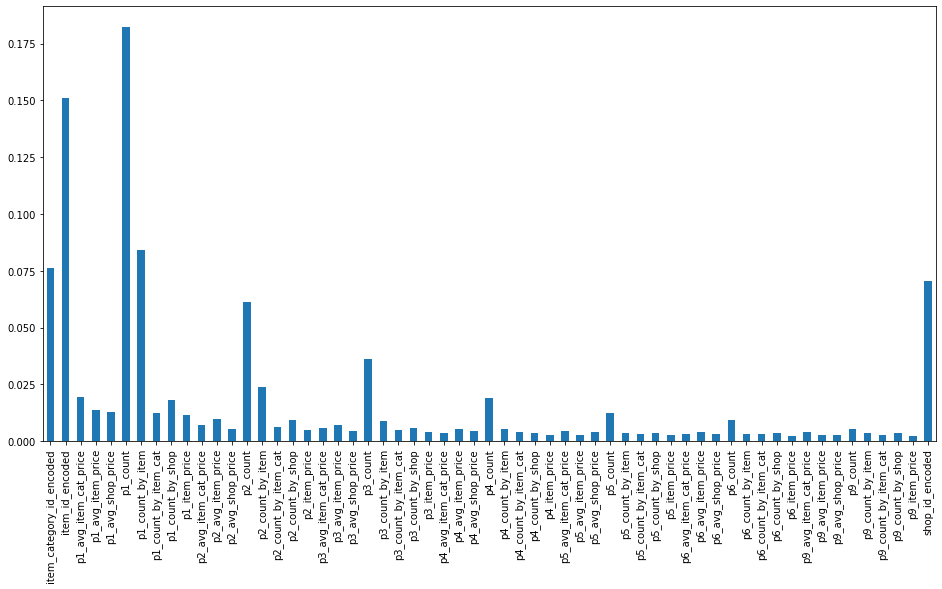

In [55]:

pd.Series(rfr.feature_importances_, index=X_train.columns).plot.bar(figsize=(16, 8))

<AxesSubplot:>

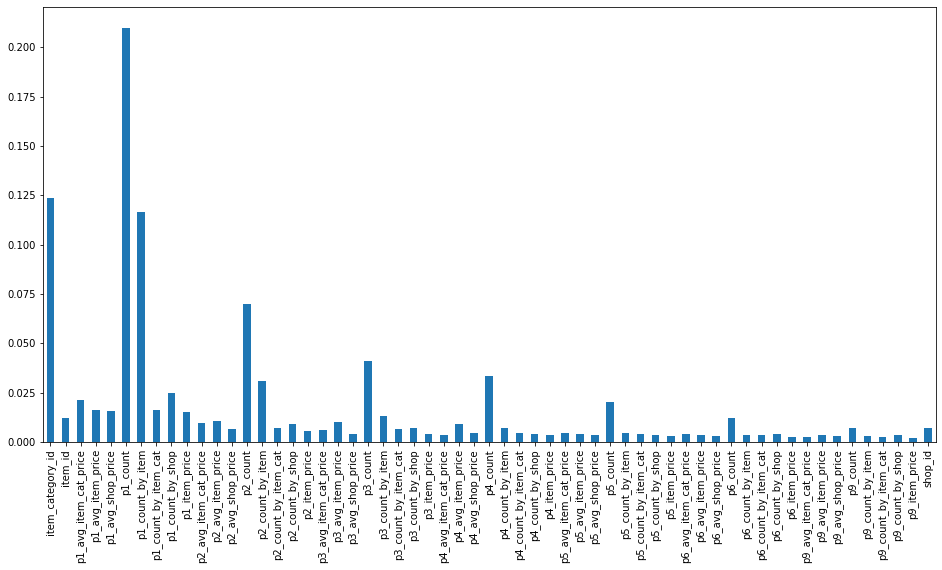

In [101]:

pd.Series(rfr.feature_importances_, index=X_train.columns).plot.bar(figsize=(16, 8))

### LightGBM

In [56]:
import lightgbm as lgb

In [58]:


# categorical_features = ['shop_id', 'item_id', 'item_category_id']
train_lgb_data = lgb.Dataset(X_train, label=Y_train, )
params = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'num_leaves': 900,
    'n_estimators': 100,
    'sub_feature': 0.2,
    'metric': 'mse'
    
}
lgb_model = lgb.train(params, train_lgb_data, )



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.417034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12959
[LightGBM] [Info] Number of data points in the train set: 4926600, number of used features: 59
[LightGBM] [Info] Start training from score -0.350164


In [59]:
prediction = lgb_model.predict(X_val, )
prediction = inverse_scaling(prediction, 'count')
metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
result = pd.Series({name: metric(inverse_scaling(Y_val, 'count'), prediction) for name, metric in metrics.items()})
result

rmse    0.618550
r2      0.584782
dtype: float64

<AxesSubplot:>

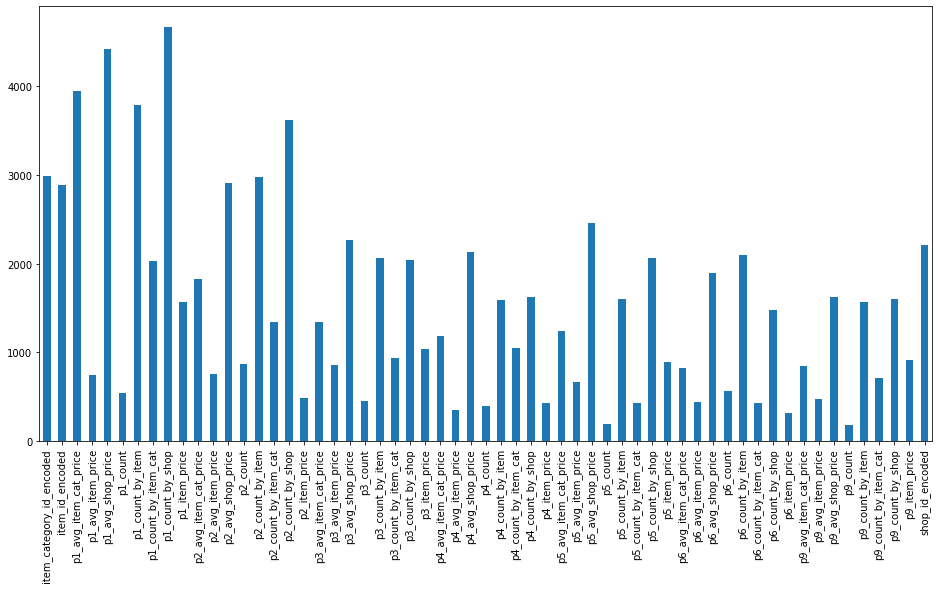

In [60]:

pd.Series(lgb_model.feature_importance(), index=X_train.columns).plot.bar(figsize=(16, 8))



### Lightgbm Hyper parameter search

In [187]:
params = {
    'max_depth': [16, 64,  -1],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [16, 50, 100,],
    'n_estimators': [40, 100],
    'subsample': [1],
    'subsample_freq': [1],
    'metric': ['mse']
}

def score_func(y_true, y_pred):
    y_true = inverse_scaling(y_true, 'count')
    y_pred = inverse_scaling(y_pred, 'count')
    return mean_squared_error(y_true, y_pred, squared=False)

lgb_model = lgb.LGBMRegressor(silent=False)
gs = GridSearchCV(lgb_model,
                  param_grid=params,
                  cv=5,
                  n_jobs=-1,
                  verbose=10,
                  scoring=make_scorer(score_func, greater_is_better=False)
                 )


In [188]:
gs.fit(X_train, Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 55

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.548128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13264
[LightGBM] [Info] Number of data points in the train set: 4498200, number of used features: 59
[LightGBM] [Info] Start training from score -0.135977


GridSearchCV(cv=5, estimator=LGBMRegressor(silent=False), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [16, 64, -1], 'metric': ['mse'],
                         'n_estimators': [40, 100], 'num_leaves': [16, 50, 100],
                         'subsample': [1], 'subsample_freq': [1]},
             scoring=make_scorer(score_func, greater_is_better=False),
             verbose=10)

In [190]:
gs.best_estimator_

LGBMRegressor(max_depth=64, metric='mse', num_leaves=50, silent=False,
              subsample=1, subsample_freq=1)

In [196]:
best_param = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').iloc[0]['params']
best_param

{'learning_rate': 0.1,
 'max_depth': -1,
 'metric': 'mse',
 'n_estimators': 100,
 'num_leaves': 50,
 'subsample': 1,
 'subsample_freq': 1}

In [189]:
import joblib
joblib.dump(gs, 'lgb_gridsearch.pickle')

['lgb_gridsearch.pickle']

In [199]:
categorical_features = ['shop_id', 'item_id', 'item_category_id']
train_lgb_data = lgb.Dataset(X_train, label=Y_train, categorical_feature=categorical_features)
lgb_model = lgb.train(best_param, train_lgb_data, )


/usr/local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.416888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18031
[LightGBM] [Info] Number of data points in the train set: 4498200, number of used features: 59
[LightGBM] [Info] Start training from score -0.135977


In [200]:
prediction = lgb_model.predict(X_val, categorical_feature=categorical_features)
prediction = inverse_scaling(prediction, 'count')
metrics = {'rmse': lambda *args: mean_squared_error(*args, squared=False),
           'r2': r2_score
          }
result = pd.Series({name: metric(inverse_scaling(Y_val, 'count'), prediction) for name, metric in metrics.items()})
result

rmse    1.376958
r2      0.605059
dtype: float64

### Predict

In [61]:


prediction = rfr.predict(X_test) 
prediction = inverse_scaling(prediction, 'count')



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.1s
[Para

In [63]:
submission_df = pd.DataFrame(np.array([test_data['ID'].values, prediction]).T,
                             columns=['ID', 'item_cnt_month'], )
submission_df['ID'] = submission_df['ID'].astype(int)
submission_df

,ID,item_cnt_month
0,0,1.000000
1,1,1.000001
2,2,1.782149
3,3,1.000000
4,4,1.000001
...,...,...
214195,214195,1.360664
214196,214196,1.000001
214197,214197,1.000000
214198,214198,1.000001


<AxesSubplot:>

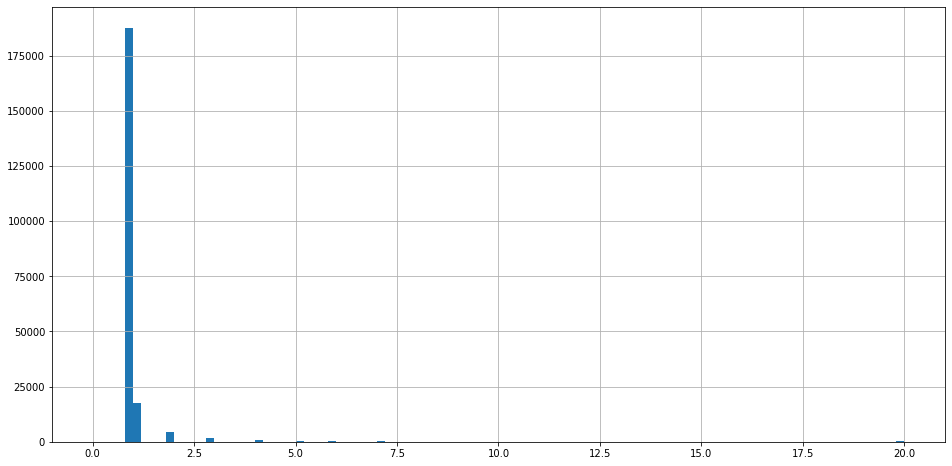

In [69]:
inverse_scaling(Y_val, 'count').hist(bins=100, figsize=(16, 8))

<AxesSubplot:>

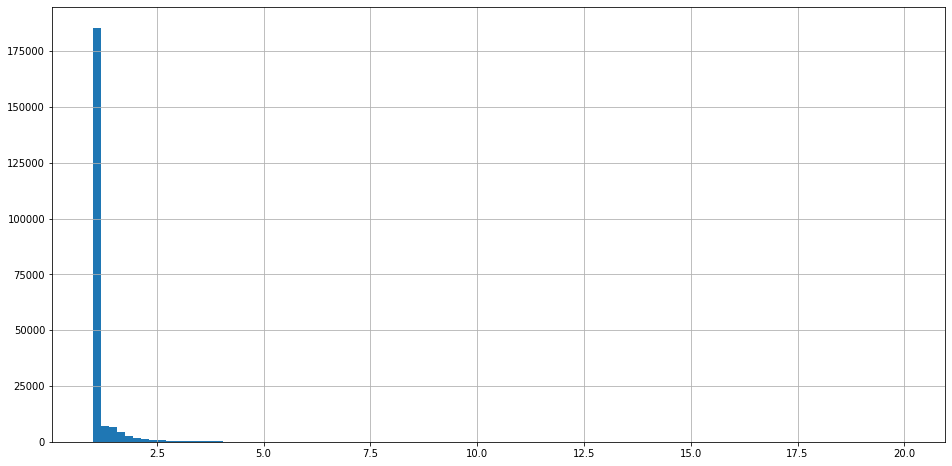

In [66]:
submission_df['item_cnt_month'].hist(bins=100, figsize=(16, 8))

In [64]:
submission_df.to_csv('submission/outputv3_mean_encoding.csv', index=False)